# EDA Analysis on TTC Bus Delay Data

This data was sourced from open.toronto.ca website. Raw data can be found [here](https://open.toronto.ca/dataset/ttc-bus-delay-data/).

While there are multiple years of data available on this website, we are using 2024 data.

Our goal is to see how many buses are delayed and by how much time.

Let's get started with the EDA!

In [1]:
# This code block will be used for all library imports. 
import pandas as pd
import altair as alt

# Simplify working with large datasets in Altair
alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

## Loading and Fixing Data

In [2]:
# Let's load the data.
# the Dates column is parsed through date argument to make sure it is seen as datetime object.
ttc = pd.read_csv('data/ttc-bus-delay-data-2024.csv', parse_dates=['Date'])

/var/folders/jq/qyhs6j1j1nz7gpn_83j90d5w0000gn/T/ipykernel_97242/317655958.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ttc = pd.read_csv('data/ttc-bus-delay-data-2024.csv', parse_dates=['Date'])


In [3]:
ttc.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2024-01-01,89,02:08,Monday,KEELE AND GLENLAKE,Vision,10,20,N,7107
1,2024-01-01,39,02:30,Monday,FINCH STATION,General Delay,20,40,NaN,8914
2,2024-01-01,300,03:13,Monday,BLOOR AND MANNING,General Delay,0,0,NaN,8562
3,2024-01-01,65,03:23,Monday,PARLIAMENT AND BLOOR,Security,0,0,N,8574
4,2024-01-01,113,03:37,Monday,MAIN STATION,Security,0,0,NaN,8541


In [4]:
# .shape shows up how big our data is
print(f"This dataset has {ttc.shape[0]} rows and {ttc.shape[1]} columns")
ttc.shape

This dataset has 45300 rows and 10 columns


(45300, 10)

In [5]:
# .info tells us about the object type for each column
# we can see 'Date' column was read as datetime object
ttc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45300 entries, 0 to 45299
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       45300 non-null  datetime64[ns]
 1   Route      44861 non-null  object        
 2   Time       45300 non-null  object        
 3   Day        45300 non-null  object        
 4   Location   45300 non-null  object        
 5   Incident   45300 non-null  object        
 6   Min Delay  45300 non-null  int64         
 7   Min Gap    45300 non-null  int64         
 8   Direction  38343 non-null  object        
 9   Vehicle    45300 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 3.5+ MB


In [6]:
# Let's also fix the 'Time' column
ttc1 = ttc.copy() # preserving the original

# Converting column to datetime object
ttc1['Time'] = pd.to_datetime(ttc['Time']).dt.time

/var/folders/jq/qyhs6j1j1nz7gpn_83j90d5w0000gn/T/ipykernel_97242/4215578345.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ttc1['Time'] = pd.to_datetime(ttc['Time']).dt.time


Now, let's split 'Date' column into 'Date_' and 'Month' (year is not needed since this is for 2024), and convert 'Time' into 'Hours' so it more useful in the analysis later on.

In [7]:
ttc1['Date_'] = ttc1['Date'].dt.date
ttc1['Month'] = ttc1['Date'].dt.month
ttc1['Hour'] = ttc1['Time'].map(lambda x: x.hour) # used ChatGPT for this conversion

In [8]:
# Let's drop the 'Date' and 'Time' column since they are no longer needed
ttc1 = ttc1.drop(columns=['Date', 'Time'])

<br>

___
## Preprocessing
Now that the data is loaded in, we want to make sure we don't perform our analysis will null values. So, we will go through and identify any columns that have big number of null values and determine if they are worth keeping for analysis or not. 

In [9]:
ttc1.isna().sum()

Route         439
Day             0
Location        0
Incident        0
Min Delay       0
Min Gap         0
Direction    6957
Vehicle         0
Date_           0
Month           0
Hour            0
dtype: int64

In [10]:
# 'Direction' column has a lot null values. Let's see if these rows can be dropped
ttc1[ttc1['Direction'].isna()].head(20)

,Route,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Date_,Month,Hour
1,39,Monday,FINCH STATION,General Delay,20,40,NaN,8914,2024-01-01,1,2
2,300,Monday,BLOOR AND MANNING,General Delay,0,0,NaN,8562,2024-01-01,1,3
4,113,Monday,MAIN STATION,Security,0,0,NaN,8541,2024-01-01,1,3
12,600,Monday,LAKESHORE AND THIRTY S,Cleaning - Unsanitary,25,50,NaN,8798,2024-01-01,1,5
13,300,Monday,KIPLING STATION,Emergency Services,0,0,NaN,3330,2024-01-01,1,5
23,41,Monday,KEELE AND IAN MACDONAL,Diversion,780,793,NaN,7251,2024-01-01,1,7
24,85,Monday,TORONTO ZOO,Security,20,40,NaN,3495,2024-01-01,1,7
27,NaN,Monday,EGLINTON DIVISION,Operations - Operator,0,0,NaN,0,2024-01-01,1,8
28,12,Monday,KENNEDY STATION,Emergency Services,30,60,NaN,8408,2024-01-01,1,8
34,900,Monday,KIPLING STATION,Operations - Operator,14,28,NaN,3341,2024-01-01,1,9


<br>
Maybe deleting the rows isn't such a good idea because it makes up for a lot of overall data in the dataset. Instead, let's drop the column since we already have information about the route. For that reason, it is also okay to drop 'Vehicle' column as it is not needed for our goal of observing delays in busses.

In [39]:
ttc_clean = ttc1.drop(columns=['Direction', 'Vehicle'])
ttc_clean.head()

,Route,Day,Location,Incident,Min Delay,Min Gap,Date_,Month,Hour
0,89,Monday,KEELE AND GLENLAKE,Vision,10,20,2024-01-01,1,2
1,39,Monday,FINCH STATION,General Delay,20,40,2024-01-01,1,2
2,300,Monday,BLOOR AND MANNING,General Delay,0,0,2024-01-01,1,3
3,65,Monday,PARLIAMENT AND BLOOR,Security,0,0,2024-01-01,1,3
4,113,Monday,MAIN STATION,Security,0,0,2024-01-01,1,3


Now, let's look at the Route column and its NaNs. This column is particularly important for us for our goal.

In [40]:
na_route = ttc1[ttc1['Route'].isna()]
na_route.head(10)

,Route,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Date_,Month,Hour
27,NaN,Monday,EGLINTON DIVISION,Operations - Operator,0,0,NaN,0,2024-01-01,1,8
69,NaN,Monday,GUILDWOOD AND KINGSTON,Utilized Off Route,0,0,NaN,8491,2024-01-01,1,19
213,NaN,Tuesday,QUEENSWAY GARAGE,Mechanical,0,0,NaN,8136,2024-01-02,1,16
248,NaN,Tuesday,3RD FLOOR GUNN BUILDIN,Operations - Operator,0,0,NaN,0,2024-01-02,1,20
293,NaN,Wednesday,WILSON TRAINING OPERAT,Operations - Operator,0,0,NaN,0,2024-01-03,1,6
350,NaN,Wednesday,RUSSELL CARHOUSE,Mechanical,0,0,NaN,349,2024-01-03,1,14
602,NaN,Thursday,FINCH STATION,Operations - Operator,12,24,N,3253,2024-01-04,1,17
624,NaN,Thursday,ARROW GARAGE,Collision - TTC,0,0,NaN,1371,2024-01-04,1,21
638,NaN,Thursday,123 PARKWAY FOREST DRI,Utilized Off Route,0,0,NaN,3400,2024-01-04,1,0
659,NaN,Friday,MOUNT DENNIS DIVISION,Operations - Operator,0,0,NaN,0,2024-01-05,1,5


In [41]:
# Now, we will see how many for NaN routes have delays
na_route[na_route['Min Delay'] == 0].count()

Route          0
Day          363
Location     363
Incident     363
Min Delay    363
Min Gap      363
Direction     68
Vehicle      363
Date_        363
Month        363
Hour         363
dtype: int64

Since all the NaN routes have 0 delays, it is safe to drop these rows. We will also remove all other null values to ensure a clean dataset to work with

In [42]:
ttc_clean = ttc_clean.dropna()
ttc_clean.isna().sum()

Route        0
Day          0
Location     0
Incident     0
Min Delay    0
Min Gap      0
Date_        0
Month        0
Hour         0
dtype: int64

In [43]:
ttc_clean.head()

,Route,Day,Location,Incident,Min Delay,Min Gap,Date_,Month,Hour
0,89,Monday,KEELE AND GLENLAKE,Vision,10,20,2024-01-01,1,2
1,39,Monday,FINCH STATION,General Delay,20,40,2024-01-01,1,2
2,300,Monday,BLOOR AND MANNING,General Delay,0,0,2024-01-01,1,3
3,65,Monday,PARLIAMENT AND BLOOR,Security,0,0,2024-01-01,1,3
4,113,Monday,MAIN STATION,Security,0,0,2024-01-01,1,3


<br>

___
## Visualizing

Now it's the fun part: visualizations!

___
Let's look at how the delays are distributed in this data

In [44]:
# Filter data
ttc_filtered = ttc_clean[ttc_clean['Min Delay'] < 200]

# Creating histogram
delay_dist = alt.Chart(ttc_filtered).mark_bar().encode(
    alt.X('Min Delay:Q', bin=alt.Bin(maxbins=50), title='Delay (in minutes)'),
    alt.Y('count()', title='Frequency')
).properties(
    title='Distribution of Delays',
)

# Display
delay_dist

alt.Chart(...)

This plot shows that majority of the delays occur within 0 to 25 mins. This can indicate that most delays are short in duration.

___
Now let's take a look at top 20 routes with highest delay incidents

In [45]:
# Group by 'Route' and count the occurrences
route_counts = ttc_clean.groupby('Route').size().reset_index(name='Count')

# Sort counts in descending order and get the top 20 routes
route_counts = route_counts.sort_values('Count', ascending=False)
top_routes = route_counts.head(20)
#top_routes

# Creating bar chart
top20_delay_routes = alt.Chart(top_routes).mark_bar().encode(
    alt.X('Route:N', title='Route', sort=alt.EncodingSortField(field='Count', order='descending')),  # 'N' for nominal (categorical)
    alt.Y('Count:Q', title='Count'),  # 'Q' for quantitative (numerical)
    alt.Color('Count:Q')
).properties(
    title='Top 20 Routes with Highest Delay Incidents',
)

# Display
top20_delay_routes

alt.Chart(...)

This plot shows that majority of the incidents are occuring on route 32 with close to 1,400 counts of delays, followed by route 32 and 36.
As we move towards other routes, there seems to be a smooth decline in delay counts, showing a decreasing trend.

___
(@Yichun, I am putting some ideas here for the charts, feel free to do others)
- Top 10 locations with Highest Delay Counts
- Delay Counts by Month, Day of the Week, Hour of the Day etc. 
- Delay Incident Types

# Analysis

We want to use a simple predictive model like decision tree to predict future delays.

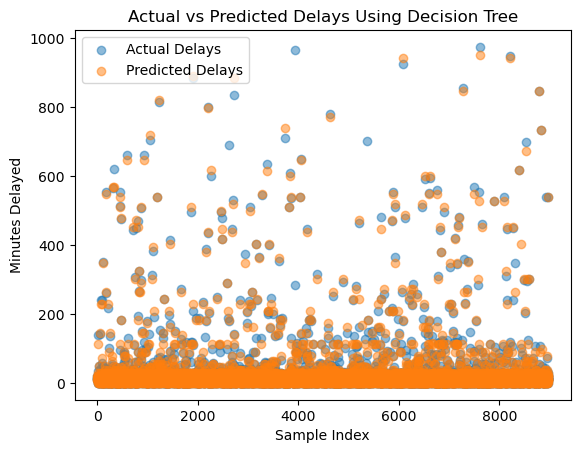

In [60]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

numeric_features = ['Min Gap']
categorical_features = ['Location', 'Day', 'Incident']

preprocessor = ColumnTransformer(
   transformers=[
       ('num', StandardScaler(), numeric_features),
       ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
   ]
)

model_pipeline = Pipeline(steps=[
   ('preprocessor', preprocessor),
   ('model', DecisionTreeRegressor(random_state=123, max_depth=10))
])

ttc_lr = ttc_clean.copy()
X = ttc_lr.drop('Min Delay', axis=1)
y = ttc_lr['Min Delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

model_pipeline.fit(X_train, y_train)
predictions = model_pipeline.predict(X_test)

plt.scatter(range(len(y_test)), y_test, label='Actual Delays', alpha=0.5)
plt.scatter(range(len(predictions)), predictions, label='Predicted Delays', alpha=0.5)
plt.title('Actual vs Predicted Delays Using Decision Tree')
plt.xlabel('Sample Index')
plt.ylabel('Minutes Delayed')
plt.legend()
plt.show()

## Analysis of results

1. The predicted results seem clustered at the lower values of "minutes delayed" which indicate that there may be underfitting.
2. Decision trees struggle with high variance of values, which is shown in this analysis.
3. We could potentially tune the max_depth of the decision tree but the accuracy might not improve much.